In [2]:
#!/usr/bin/env python
"""

"""

import sys
import os
import re
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.pipeline import Pipeline

def load_data():

    data_dir = os.path.join(".","sample_data")
    df = pd.read_csv(os.path.join(data_dir,r"aavail-target.csv"))

    ## pull out the target and remove uneeded columns
    _y = df.pop('is_subscriber')
    y = np.zeros(_y.size)
    y[_y==0] = 1 
    df.drop(columns=['customer_id','customer_name'],inplace=True)
    return(y,df)


## variables
rs = 42

## preprocessing pipeline
numeric_features = ['age', 'num_streams']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['country', 'subscriber_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

    


In [3]:


## load the data
y,df = load_data()
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=rs)

pipe  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('dt', DecisionTreeClassifier(min_samples_leaf=100))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


## extract feature names 
feature_names = np.hstack([numeric_features,
                          preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names()])
feature_names = [re.sub("x\d_","",fn) for fn in feature_names]
target_names = ['subscriber','churned']
print(feature_names)
print(classification_report(y_test, y_pred, target_names=target_names))


## make plot
try:
  import graphviz        
except:
  print("not creating tree since graphviz is not installed")
  sys.exit()

dot_data = export_graphviz(pipe['dt'], out_file=None, 
                              feature_names=feature_names,  
                              class_names=target_names,  
                              filled=True, rounded=True, 
                              special_characters=True)

graph = graphviz.Source(dot_data)  
graph.render("aavail_churn_dt")
print("Graph saved in your working directory.")



['age', 'num_streams', 'singapore', 'united_states', 'aavail_basic', 'aavail_premium', 'aavail_unlimited']
              precision    recall  f1-score   support

  subscriber       0.83      0.91      0.87       142
     churned       0.71      0.55      0.62        58

    accuracy                           0.81       200
   macro avg       0.77      0.73      0.75       200
weighted avg       0.80      0.81      0.80       200

Graph saved in your working directory.


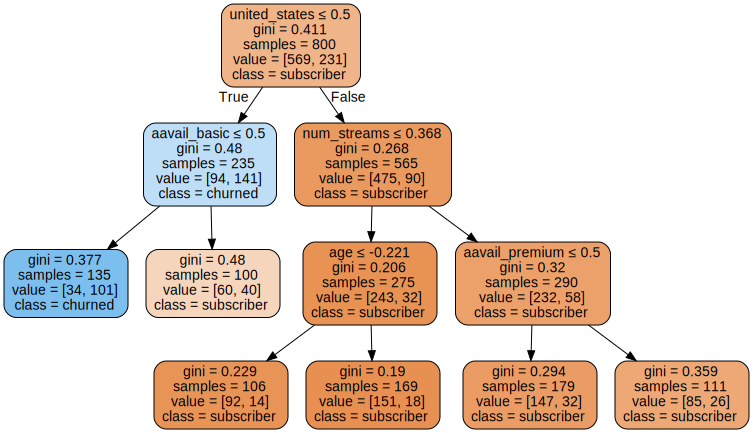

In [4]:
graph